# Labels Co-occurence Analysis and Image Similarity via Embeddings

## Hi, you! Welcome! 🙌


This notebook provides a quick overview on **how the labels are distributed and how they co-occur** throughout the Challenge datasets.

Also, we make an **image similarity analysis** using embeddings extracted from a Deep Learning model (EfficientNet B0).



![](https://i.imgur.com/j5zjnsn.png)

# 1) Login to AIcrowd 🤩

In [ ]:
#@title Login to AIcrowd
!pip install -U aicrowd-cli > /dev/null
!aicrowd login 2> /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Please login here: https://api.aicrowd.com/auth/W4xcpyM4szsUs2iovEvi3sgh2Y7Mswn29-ewbJZcKZ8
API Key valid
Gitlab access token valid
Saved details successfully!


# 2) Setup magically, run the below cell 😉

In [ ]:
#@title Magic Box ⬛ { vertical-output: true, display-mode: "form" }
try:
  import os
  if first_run and os.path.exists("/content/data-purchasing-challenge-2022-starter-kit/data/public_training"):
    first_run = False
except:
  first_run = True

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
purchased_labels = None

if first_run:
  %cd /content/
  !git clone http://gitlab.aicrowd.com/zew/data-purchasing-challenge-2022-starter-kit.git > /dev/null
  %cd data-purchasing-challenge-2022-starter-kit
  !aicrowd dataset list -c data-purchasing-challenge-2022
  !aicrowd dataset download -c data-purchasing-challenge-2022 *-v0.2-rc4.zip
  !mkdir -p data/
  !mv *.zip data/ && cd data && echo "Extracting dataset..." && ls *.zip | xargs -n1 -I{} bash -c "unzip -q {}"


def run_pre_training_phase():
  from run import ZEWDPCBaseRun
  run = ZEWDPCBaseRun()
  run.pre_training_phase = pre_training_phase
  run.pre_training_phase(self=run, training_dataset=training_dataset)
  # NOTE:It is critical that the checkpointing works in a self-contained way
  #      As, the evaluators might choose to run the different phases separately.
  run.save_checkpoint("/tmp/pretrainig_phase_checkpoint.pickle")

def run_purchase_phase():
  from run import ZEWDPCBaseRun
  run = ZEWDPCBaseRun()
  run.pre_training_phase = pre_training_phase
  run.purchase_phase = purchase_phase
  run.load_checkpoint("/tmp/pretrainig_phase_checkpoint.pickle")
  # Hacky way to make it work in notebook
  unlabelled_dataset.purchases = set()

  global purchased_labels
  purchased_labels = run.purchase_phase(self=run, unlabelled_dataset=unlabelled_dataset, training_dataset=training_dataset, purchase_budget=1500, compute_budget=51*60)
  
  run.save_checkpoint("/tmp/purchase_phase_checkpoint.pickle")

  del run

def run_prediction_phase():
  from run import ZEWDPCBaseRun
  run = ZEWDPCBaseRun()
  run.pre_training_phase = pre_training_phase
  run.purchase_phase = purchase_phase
  run.prediction_phase = prediction_phase
  run.load_checkpoint("/tmp/purchase_phase_checkpoint.pickle")
  run.prediction_phase(self=run, test_dataset=val_dataset)
  del run

def run_post_purchase_training_phase():
  import torch
  from evaluator.evaluation_metrics import get_zew_dpc_metrics
  from evaluator.utils import instantiate_purchased_dataset
  from evaluator.trainer import ZEWDPCTrainer

  purchased_dataset = instantiate_purchased_dataset(unlabelled_dataset, purchased_labels)
  aggregated_dataset = torch.utils.data.ConcatDataset(
      [training_dataset, purchased_dataset]
  )
  print("Training Dataset Size: ", len(training_dataset))
  print("Purchased Dataset Size: ", len(purchased_dataset))
  print("Aggregataed Dataset Size: ", len(aggregated_dataset))

  trainer = ZEWDPCTrainer(num_classes=6, use_pretrained=True)
  trainer.train(
      training_dataset, num_epochs=10, validation_percentage=0.1, batch_size=5
  )

  y_pred = trainer.predict(val_dataset)
  y_true = val_dataset_gt._get_all_labels()

  metrics = get_zew_dpc_metrics(y_true, y_pred)

  f1_score = metrics["F1_score_macro"]
  accuracy_score = metrics["accuracy_score"]
  hamming_loss_score = metrics["hamming_loss"]

  print("\n\n==================")
  print("F1 Score: ", f1_score)
  print("Accuracy Score: ", accuracy_score)
  print("Hamming Loss: ", hamming_loss_score)


/content
Cloning into 'data-purchasing-challenge-2022-starter-kit'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 306 (delta 129), reused 197 (delta 119), pack-reused 99
Receiving objects: 100% (306/306), 80.45 KiB | 8.04 MiB/s, done.
Resolving deltas: 100% (183/183), done.
/content/data-purchasing-challenge-2022-starter-kit
                          Datasets for challenge #1024                          
┌───┬─────────────────────────┬──────────────────────────────────────┬─────────┐
│ # │ Title                   │ Description                          │    Size │
├───┼─────────────────────────┼──────────────────────────────────────┼─────────┤
│ 0 │ training-v0.2-rc4.zip   │ Training data for round 2            │  97 MiB │
│ 1 │ debug-v0.2-rc4.zip      │ Debug data for round 2               │   6 MiB │
│ 2 │ validation-v0.2-rc4.zip │ Validation dataset for round 2       │ 292 MiB │

# 3) Writing your code implementation! ✍️

## a) Runtime Packages

In [ ]:
#@title a) Runtime Packages<br/><small>Important: Add the packages required by your code here. (space separated)</small> { run: "auto", display-mode: "form" }
apt_packages = "build-essential vim" #@param {type:"string"}
pip_packages = "scikit-image pandas timeout-decorator==0.5.0 numpy torchmetrics" #@param {type:"string"}

!apt install -y $apt_packages git-lfs
!pip install $pip_packages

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
The following additional packages will be installed:
  libgpm2 vim-common vim-runtime xxd
Suggested packages:
  gpm ctags vim-doc vim-scripts
The following NEW packages will be installed:
  git-lfs libgpm2 vim vim-common vim-runtime xxd
0 upgraded, 6 newly installed, 0 to remove and 39 not upgraded.
Need to get 8,854 kB of archives.
After this operation, 40.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xxd amd64 2:8.0.1453-1ubuntu1.8 [49.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 vim-common all 2:8.0.1453-1ubuntu1.8 [71.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgpm2 amd64 1.20.7-5 [15.1 kB]
Get:5 http://archive.ubuntu.com/ubun

## b) Load Dataset

In [ ]:
from evaluator.dataset import ZEWDPCBaseDataset, ZEWDPCProtectedDataset
DATASET_SHUFFLE_SEED = 1022022

# Instantiate Training Dataset
training_dataset = ZEWDPCBaseDataset(
    images_dir="./data/training/images",
    labels_path="./data/training/labels.csv",
    shuffle_seed=DATASET_SHUFFLE_SEED,
)
# Instantiate Unlabelled Dataset
unlabelled_dataset = ZEWDPCProtectedDataset(
    images_dir="./data/unlabelled/images",
    labels_path="./data/unlabelled/labels.csv",
    purchase_budget=1500,  # Configurable Parameter
    shuffle_seed=DATASET_SHUFFLE_SEED,
)
# Instantiate Validation Dataset
val_dataset = ZEWDPCBaseDataset(
    images_dir="./data/validation/images",
    labels_path="./data/validation/labels.csv",
    drop_labels=True,
    shuffle_seed=DATASET_SHUFFLE_SEED,
)
# A second instantiation of the validation test with the labels present
#       - helpful later, when computing the scores.
val_dataset_gt = ZEWDPCBaseDataset(
    images_dir="./data/validation/images",
    labels_path="./data/validation/labels.csv",
    drop_labels=False,
    shuffle_seed=DATASET_SHUFFLE_SEED,
)

## Training

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import abc
import datetime
import torch
import copy
import pandas as pd
import random
import math
import torchmetrics

from torch import nn
from torchvision import models
from torch.optim import Adam, SGD, lr_scheduler
from torchvision import transforms as T
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from sklearn.metrics import precision_score, accuracy_score, multilabel_confusion_matrix, f1_score
from scipy.spatial import distance
#from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from evaluator.exceptions import OutOfBudetException
from evaluator.evaluation_metrics import get_zew_dpc_metrics
from evaluator.dataset import ZEWDPCBaseDataset, ZEWDPCProtectedDataset, ZEWDPCRuntimeDataset
from evaluator.utils import (
    instantiate_purchased_dataset,
    AverageMeter,
)

torch.manual_seed(17)
np.random.seed(17)

In [ ]:
label_train = pd.read_csv(
    '/content/data-purchasing-challenge-2022-starter-kit/data/training/labels.csv',
    header=0)

label_unlabelled = pd.read_csv(
    '/content/data-purchasing-challenge-2022-starter-kit/data/unlabelled/labels.csv',
    header=0)

label_validation = pd.read_csv(
    '/content/data-purchasing-challenge-2022-starter-kit/data/validation/labels.csv',
    header=0)

label_enc = ['scratch_small', 'scratch_large', 'dent_small', 'dent_large', 'stray_particle', 'discoloration']

In [ ]:
label_train['no_mark'] = (label_train.iloc[:,1:] == 0).all(axis=1).astype(int)
label_unlabelled['no_mark'] = (label_unlabelled.iloc[:,1:] == 0).all(axis=1).astype(int)
label_validation['no_mark'] = (label_validation.iloc[:,1:] == 0).all(axis=1).astype(int)

label_train['total'] = (label_train.iloc[:,1:]).sum(axis=1).astype(int)
label_unlabelled['total'] = (label_unlabelled.iloc[:,1:]).sum(axis=1).astype(int)
label_validation['total'] = (label_validation.iloc[:,1:]).sum(axis=1).astype(int)

label_train['type'] = 0 # training samples are mapped to 0
label_unlabelled['type'] = 1 # training samples are mapped to 1
label_validation['type'] = 2 # training samples are mapped to 2

In [ ]:
label_all = pd.concat([label_train, label_unlabelled, label_validation], ignore_index=True).reset_index().drop('index', axis=1)

## Now into the fun part

Now that we have all the labels for all the datasets, let's start doing some analysis on how they behave between each other.

Text(0.5, 0, 'Label')

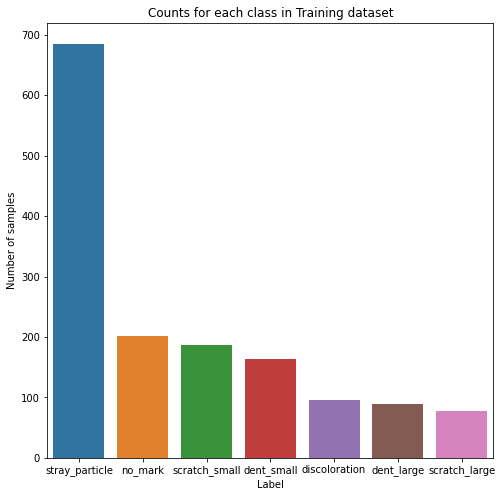

In [ ]:
counts_train = label_train.drop(['filename','type','total'], axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(8,8))
sns.barplot(y=counts_train.values, x=counts_train.index, order=counts_train.index).set(title='Counts for each class in Training dataset')
plt.ylabel('Number of samples')
plt.xlabel('Label')

In the previous round we had a lot of images without any marks (see References). This time around it looks like we are handed a training dataset that is highly unbalanced on the **stray particle** label.

Text(0.5, 0, 'Label')

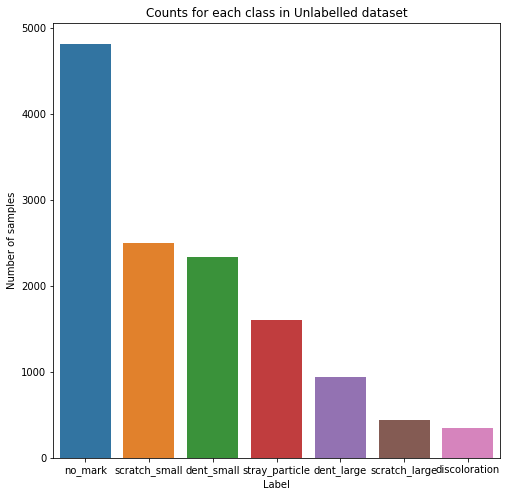

In [ ]:
counts_unlabelled = label_unlabelled.drop(['filename','type','total'], axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(8,8))
sns.barplot(y=counts_unlabelled.values, x=counts_unlabelled.index, order=counts_unlabelled.index).set(title='Counts for each class in Unlabelled dataset')
plt.ylabel('Number of samples')
plt.xlabel('Label')

The **Unlabelled** dataset looks more like the datasets from Round 1, with a high number of images withough marks. The more recurring marks are the **small scratches** and **small dents** which makes sense.

Text(0.5, 0, 'Label')

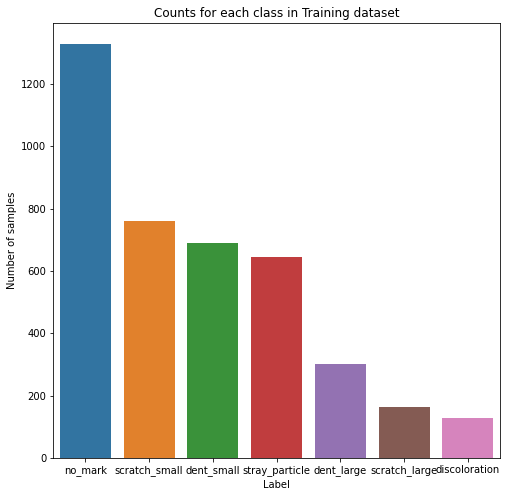

In [ ]:
counts_validation = label_validation.drop(['filename','type','total'], axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(8,8))
sns.barplot(y=counts_validation.values, x=counts_validation.index, order=counts_validation.index).set(title='Counts for each class in Training dataset')
plt.ylabel('Number of samples')
plt.xlabel('Label')

The **Validation** dataset resembles the Unlabelled dataset on the distribution for the labels. But this does not necesarilly mean that they are the same, since the marks could be distributed differently between the images.

## Co-occurence between labels

We are going to calculate the co-occurence between labels. This is, how common is to find a label (or not) when the other one is present.

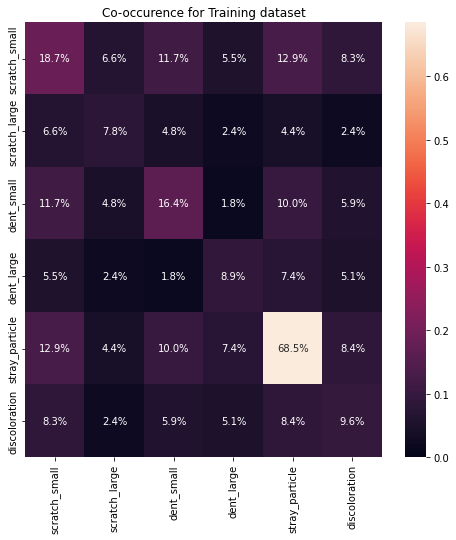

In [ ]:
plt.figure(figsize=(8,8))
training_labels_co = label_train.drop(['filename','no_mark','total','type'],axis=1).astype(int) #[label_train['total']>1].drop(['filename','no_mark','total','type'],axis=1)
coocc_t = training_labels_co.T.dot(training_labels_co)
coocc_t = coocc_t.divide(len(training_dataset))

sns.heatmap(coocc_t, annot=True, vmin=0, vmax=coocc_t.melt().value.max(), fmt='.1%').set(title='Co-occurence for Training dataset')
plt.show()

The percentages on the co-occurence matrix are over the **total samples** of the dataset.


Here we can clearly see the predominance of **stray particle** labels over the whole dataset. Also, there is over 15% of occurence for **small scratches** and **small dents**.

It is nice to see some co-occurence with high values, indicating that some labels might actually be introduced together within the images, with the **small dents & small scratches** (with over 11%), and **discoloration & small scratches** (with over 8%). I didn't consider the **stray particles** due to their high number of appearances.

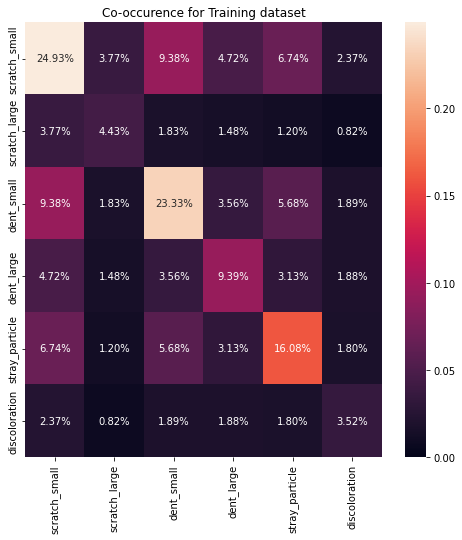

In [ ]:
plt.figure(figsize=(8,8))
unlabelled_labels_co = label_unlabelled.drop(['filename','no_mark','total','type'],axis=1).astype(int)
coocc_u = unlabelled_labels_co.T.dot(unlabelled_labels_co)
coocc_u = coocc_u.divide(len(unlabelled_dataset))

sns.heatmap(coocc_u, annot=True, vmin=0, vmax=coocc_u.melt().value.max(), fmt='.2%').set(title='Co-occurence for Training dataset')
plt.show()


On the **Unlabelled** dataset the story changes a bit, we get _a lot less_ samples for the **stray particles**, and we get a lot more **small scratches and small dents**. This may help us on reducing the amount of images we want where these classes appear, in order to increase diversity.
We also can see almost 10% of co-occurance with the aforementioned labels, indicating that they really tend to appear. Images with **discoloration** are pretty uncommon, and if you are lucky, you may find one that has **discoloration** and **large scratches**

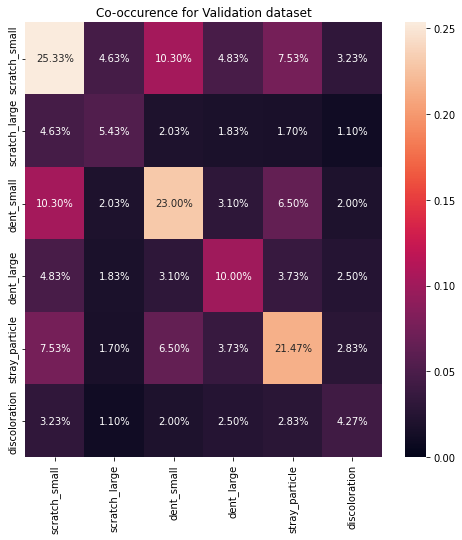

In [ ]:
plt.figure(figsize=(8,8))
validation_labels_co = label_validation.drop(['filename','no_mark','total','type'],axis=1).astype(int)
coocc_v = validation_labels_co.T.dot(validation_labels_co)
coocc_v = coocc_v.divide(len(label_validation))
sns.heatmap(coocc_v, annot=True, vmin=0, vmax=coocc_v.melt().value.max(), fmt='.2%').set(title='Co-occurence for Validation dataset')
plt.show()

Our **Validation** dataset is really similar to our **Unlabelled** dataset, and this is good, they might have been sampled from the same distribution. I would recommend further investigation on this topic...

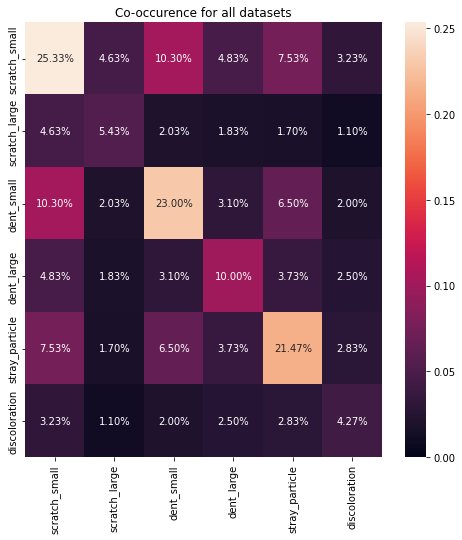

In [ ]:
plt.figure(figsize=(8,8))

all_labels_co = label_all.drop(['filename','no_mark','total','type'],axis=1).astype(int)
coocc_a = all_labels_co.T.dot(all_labels_co)
coocc_a = coocc_a.divide(len(label_all))
sns.heatmap(coocc_v, annot=True, vmin=0, vmax=coocc_v.melt().value.max(), fmt='.2%').set(title='Co-occurence for all datasets')
plt.show()

A view from all datasets together, gives us pretty much the same matrix as the **Unlabelled** dataset, which makes sense given the enormous amount of samples that it has, plus adding the **Validation** dataset,| which is pretty similar.

## But is this really usfeul?

Well, don't take my word for it, but these co-occurence matrix could be used as weights when picking images from your model's predictions. Creating some sort of index that conveys information from different steps might be useful!

# Image similary with embeddings 🛌

Doing some research I found that one of the ways of getting some information on image similarity is basically taking the images through a model and get the output on one of the layers that capture information about the images such as shapes, position, etc.

## but how? 🤔

For that end, I found this very [beautiful repository](https://https://github.com/christiansafka/img2vec), which allows with very few easy steps, taking some images and calculate their embeddings 🛌.
<br><br><br>
After that, I took the liberty of applying some **Principal Components Analysis** to reduce the dimensionality of the data and allow us to plot both the **training** and **unlabelled** datasets. This visual inspection enables us to see some differences in the structure of both datasets.

If we are able to **pinpoint the most important images for training**, we *might* be able to use this as criteria for chosing our purchase images. **The closer they are, the more similar they might be**.
<br><br><br>
**Note**: take into account that the embeddings are obtained from a pretrained model. It might be better to actually get the embeddings from our trained weights in the _pre_training_phase_, but I'll leave that to you.

In [ ]:
# We first take the class we need from the repo, here you might choose to modify
# the original code in order to input your trained model

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, cuda=False, model='efficientnet_b0', layer='default', layer_output_size=1280):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = T.Resize((224, 224))
        self.normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = T.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image or list of PIL Images
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            # VGG-11
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features # should be 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            # Densenet-121
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features # should be 1024
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            # efficientnet-b0 ~ efficientnet-b7
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)



## Onto the fun part 🏄

Go grab something to drink after running the following, and come back to a nice plot of your data looking good

In [ ]:
# Next, we are going to instantiate the class and run it through both the training
# and unlabelled dataset

img2vec = Img2Vec()
vec_length = 1280 # we are using efficientnet-b0 as default

samples = len(unlabelled_dataset) + len(training_dataset)
vec_mat = np.zeros((samples, vec_length)) # we predefine our matrix

PIL_transform = T.ToPILImage()
aux_index_un = []
aux_index_tr = [] #in case we want to retreive the indexes

print('Calculating for Unlabelled dataset')
tqdm_iter_vec = tqdm(unlabelled_dataset)

for i, sample in enumerate(tqdm_iter_vec):
    if i>= len(unlabelled_dataset): break
    idx = int(sample['idx'])
    aux_index_un.append(idx)
    img = unlabelled_dataset.__getitem__(idx).get('image')
    img = PIL_transform(img)
    vec = img2vec.get_vec(img)
    vec_mat[i, :] = vec

print('Calculating for Training dataset')
tqdm_iter_vec_tr = tqdm(training_dataset)    
for i, sample in enumerate(tqdm_iter_vec_tr):
    idx = int(sample['idx'])
    aux_index_tr.append(idx)
    img = training_dataset.__getitem__(idx).get('image')
    img = PIL_transform(img)
    vec = img2vec.get_vec(img)
    vec_mat[int(len(unlabelled_dataset))+i, :] = vec


reduced_data = PCA(n_components=2).fit_transform(vec_mat)

df_pca_un = pd.DataFrame(aux_index_un, columns = ['idx'])
df_pca_tr = pd.DataFrame(aux_index_tr, columns = ['idx'])

df_pca_un['labelled'] = 'Unlabelled'
df_pca_tr['labelled'] = 'Labelled'

df_all = df_pca_un.append(df_pca_tr).reset_index(drop=True)
df_all['x'] = reduced_data[:,0]
df_all['y'] = reduced_data[:,1]


Calculating for Unlabelled dataset


100%|██████████| 10000/10000 [10:10<00:00, 16.39it/s]


Calculating for Training dataset


100%|██████████| 1000/1000 [00:59<00:00, 16.91it/s]


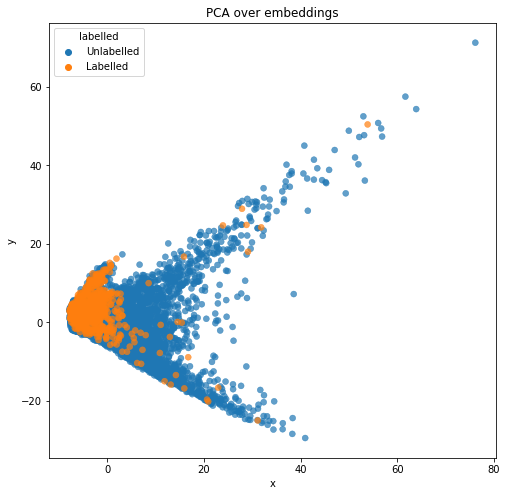

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='x', y='y', hue='labelled', data=df_all, alpha=0.7,edgecolor=None).set(title='PCA over embeddings')
plt.show()

##Wow, look at that 🐟 right there. 

I hope that you are already seeing that this may come in handy for your image selection. 

Inspecting the scatterplot we can determine that there are several images on the unlabelled dataset which embedding is out of our model's horizon.


# References

1. Some of the early steps on this notebook are based on @leocd 's original notebook, which you can find [right here](https://www.aicrowd.com/showcase/exploration-body-paint-color-dominance-image-transforms)

2. The repo for the **img2vec** function can be found [here](https://github.com/christiansafka/img2vec), go check it out, it's worth it!

# That's all folks 🐰

That is all for today, I hope you find some of this information useful!

There is some amazing people out there sharing some great tips on the challenge, be sure to check it out.

<br><br>

## If you found this insightful, please, remember to leave a 👍 and comment if you have any suggestion.